# Algorytmy macierzowe - zadanie nr 5 - Algorytmy permutacji macierzy rzadkich

"Proszę zbudować graf eliminacji dla macierzy rzadkiej używanej w zadaniu 4
(rzadka eliminacja) (bazując na swoim formacie macierzy rzadkiej z zadania 4.

Proszę napisać wybrany algorytm permutacji macierzy na swojej macierzy
rzadkiej:
1. Minimum degree
2. Cuthill-McKee
3. Nested-dissections

Proszę porównać czasy działania rzadkiej eliminacji Gaussa przed i po
permutacji macierzy"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [14]:
import numpy as np
import networkx as nx
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from matrix_functions import *

## Generowanie macierzy

In [15]:
matrix_3a = read_matrix('matrices/3a.txt')
matrix_4a = read_matrix('matrices/3a.txt')

## Graf eliminacji

Poniższe funkcje służą do konstrukcji grafu eliminacji dla zadanej macierzy w odpowiednim formacie. Funkcje przeznaczone są dla macierzy symetrycznych, generowane grafy są nieskierowane. Do implementacji i wizualizacji struktury grafów skorzystaliśmy z biblioteki networkx.

* konstrukcja grafu dla macierzy w zwykłym formacie

In [50]:
def elimination_graph_dense(matrix):
    graph = nx.Graph()
    
    n, m = matrix.shape
    
    for i in range(n):
        for j in range(i+1, m):
            if abs(matrix[i, j]) > 1e-8:
                graph.add_edge(i, j, color='silver')
    
    return graph    

* konstrukcja grafu dla macierzy w formacie CSR

In [51]:
def elimination_graph_csr(matrix):
    graph = nx.Graph()
    
    ICL, VAL, ROWPTR = matrix
    n = len(ROWPTR) - 1

    graph.add_nodes_from([x for x in range(n)])
    for row in range(n):
        for j in range(ROWPTR[row], ROWPTR[row+1]):
            if row == ICL[j]: continue
            graph.add_edge(row, ICL[j], color='silver')
            
    return graph

* rysowanie grafu

In [58]:
def draw_graph(graph, pos=None, node_size=400, figsize=(10,10)):
    if pos is None:
        pos = nx.random_layout(graph)
        
    plt.figure(figsize=figsize)
    edge_colors = colors = nx.get_edge_attributes(graph,'color').values()
    nx.draw(graph, pos=pos, with_labels=True, node_size=node_size, node_color='lightblue', edge_color=edge_colors)

* przykład dla małej macierzy z wykładu

dict_values(['silver', 'silver', 'silver'])


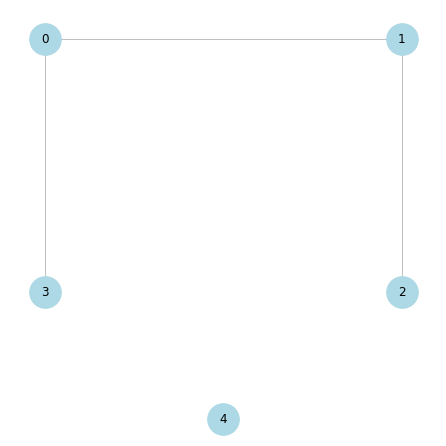

In [56]:
test_matrix = np.array([
    [1, 1, 0, 1, 0],
    [1, 2, 1, 0, 0],
    [0, 1, 3, 0, 0],
    [1, 0, 0, 4, 0],
    [0, 0, 0, 0, 5],
])

test_pos = {
    0: (0, 1),
    1: (1, 1),
    2: (1, 0),
    3: (0, 0),
    4: (0.5, -0.5)
}

draw_graph(elimination_graph_csr(convert_to_csr(test_matrix)), test_pos, 1000, (6, 6))

## Algorytm eliminacji na grafie

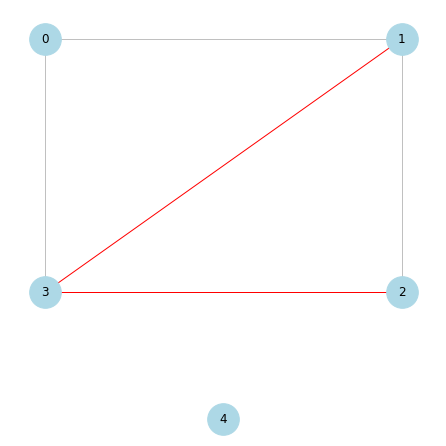

In [63]:
def graph_elimination(graph):
    graph_e = nx.Graph(graph)
    tmp_graph = nx.Graph(graph)
    nodes = list(tmp_graph.nodes())
    for k in nodes:
        adj = list(tmp_graph.neighbors(k))
        tmp_graph.remove_node(k)
        tmp_graph.remove_edges_from([(k, l) for l in adj])
        for i, x in enumerate(adj):
            for y in adj[i+1:]:
                tmp_graph.add_edge(x, y)
                graph_e.add_edge(x, y, color='r')
    return graph_e
        

graph = elimination_graph_csr(convert_to_csr(test_matrix))
graph_e = graph_elimination(graph)
draw_graph(graph_e, test_pos, 1000, (6, 6))

* graf testowej macierzy przed eliminacją

"2a. Dla podmacierzy o rozmiarze <= 100 (np. A[1:100][1:100]) wierszy proszę
zbudować i narysować graf eliminacji G0"

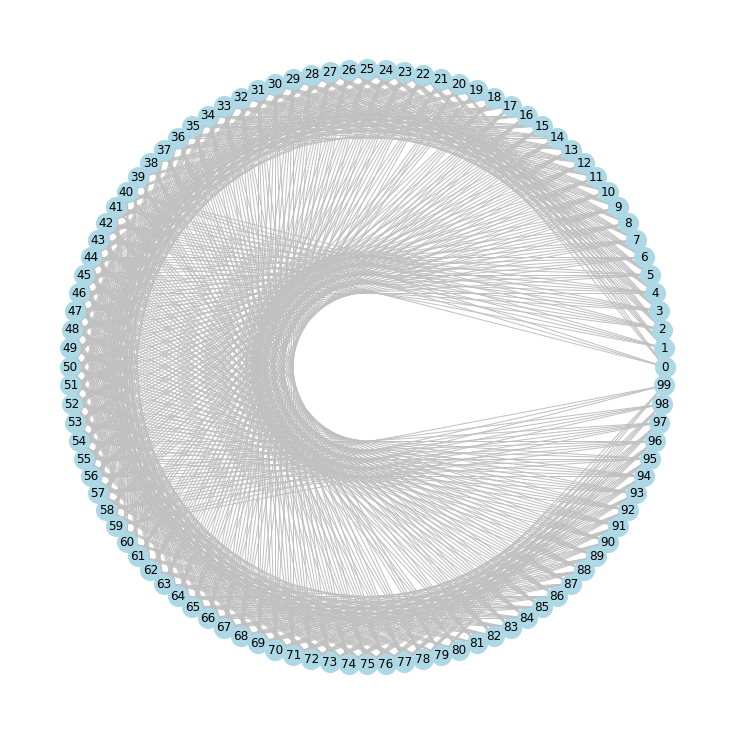

In [62]:
matrix_A = convert_to_csr(matrix_3a[:100, :100])
elim_graph = elimination_graph_csr(matrix_A)
pos = nx.circular_layout(elim_graph)
draw_graph(elim_graph, pos)

* graf testowej macierzy po eliminacji

"2b. Proszę uruchomić eliminację na tym grafie G0 i narysować nowe
krawędzie w G0"

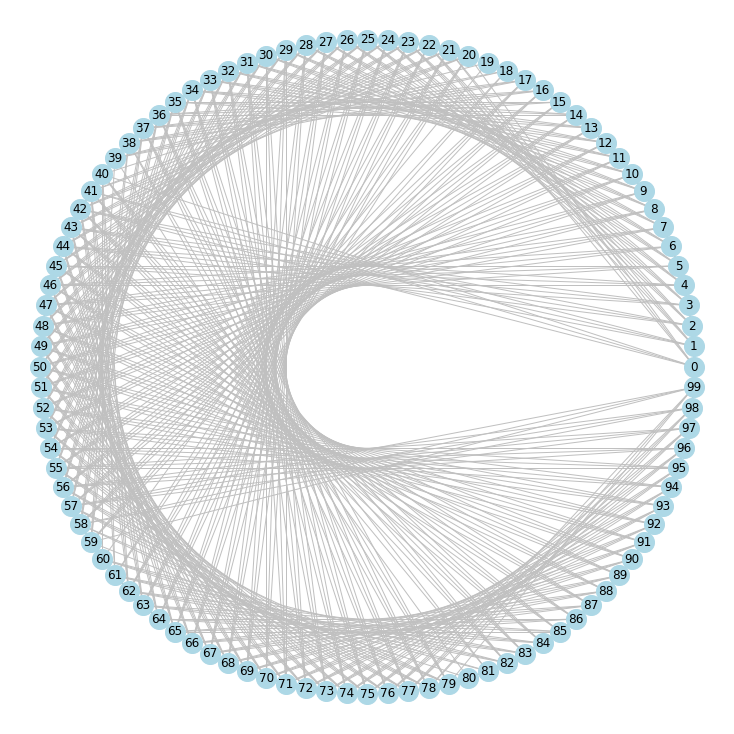

In [51]:
new_elim_graph = elimination_graph_csr(sparse_cholesky(matrix_A))
draw_graph(new_elim_graph, pos)

## Algorytm permutacji macierzy

"3. Proszę napisać i opisać kod wybranego algorytmu permutacji macierzy"

Wybraliśmy algorytm **Cuthill & McKee** oparty na przeszukiwaniu grafu wszerz.

* implementacja algorytmu

In [ ]:
def minimum_degree(G, visited):
    non_visited = [x for x in G.nodes() if not visited[x]]
    return min(non_visited, key=lambda x : G.degree(x))
        
def permutation_vector(G):
    n = G.number_of_nodes()
    queue = []
    visited = [False for x in range(n)]
    ordering = []
    
    while not all(visited):
        s = minimum_degree(G, visited)
        queue.append(s)
        while queue:
            v = queue.pop(0)
            if visited[v]: continue
            visited[v] = True
            ordering.append(v)
            for neighbor in sorted(G.neighbors(v), key=lambda x : G.degree(x)):
                if not visited[neighbor]:
                    queue.append(neighbor)
    
    return ordering

* konstrukcja macierzy permutacji

In [52]:
def permutation_matrix(ordering):
    n = len(ordering)
    P = np.zeros((n, n), dtype=np.int32)
    for row, order in enumerate(ordering):
        P[row, order] = 1
    return P

def permutation_matrix_csr(ordering):
    ICL = ordering
    VAL = [1 for _ in range(len(ICL))]
    ROWPTR = [i for i in range(len(ICL)+1)]
    
    return ICL, VAL, ROWPTR

* przykład dla małej macierzy z wykładu

In [53]:
G = elimination_graph_csr(convert_to_csr(test_matrix))

ordering = permutation_vector(G)
print("ordering:", ordering)

p_matrix = permutation_matrix(ordering)
print("\npermutation matrix:\n", p_matrix)

print("\ntest_matrix:\n", test_matrix)
print("\npermutated matrix:\n", p_matrix@test_matrix@p_matrix.T)

ordering: [4, 2, 1, 0, 3]

permutation matrix:
 [[0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]

test_matrix:
 [[1 1 0 1 0]
 [1 2 1 0 0]
 [0 1 3 0 0]
 [1 0 0 4 0]
 [0 0 0 0 5]]

permutated matrix:
 [[5 0 0 0 0]
 [0 3 1 0 0]
 [0 1 2 1 0]
 [0 0 1 1 1]
 [0 0 0 1 4]]


* permutacja macierzy testowej

"4. Proszę uruchomić macierz permutacji dla macierzy z punktu 2"

In [54]:
p_matrix = permutation_matrix(permutation_vector(elim_graph))
permutated_matrix = matmul_CSR(matmul_CSR(convert_to_csr(p_matrix), matrix_A), convert_to_csr(p_matrix.T))

* graf spermutowanej macierzy przed eliminacją

"5a. Proszę narysować graf eliminacji G0’ dla spermutowanej małej macierzy z
punktu 2"

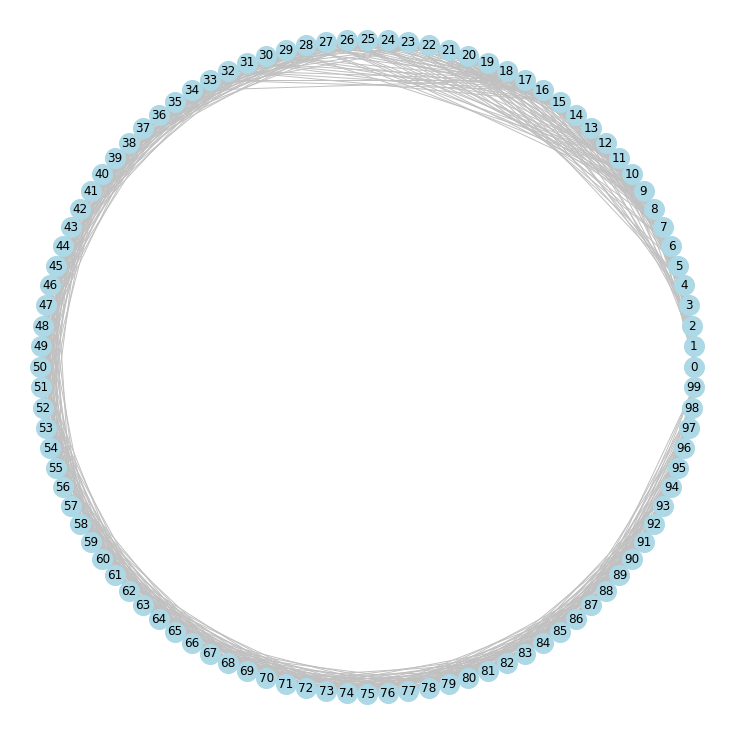

In [60]:
permutated_elim_graph = elimination_graph_csr(permutated_matrix)
draw_graph(permutated_elim_graph, pos)

* graf spermutowanej macierzy po eliminacji

"5b. Proszę uruchomić eliminację Gaussa na tym grafie G0’ i narysować nowe
krawędzie w G0"

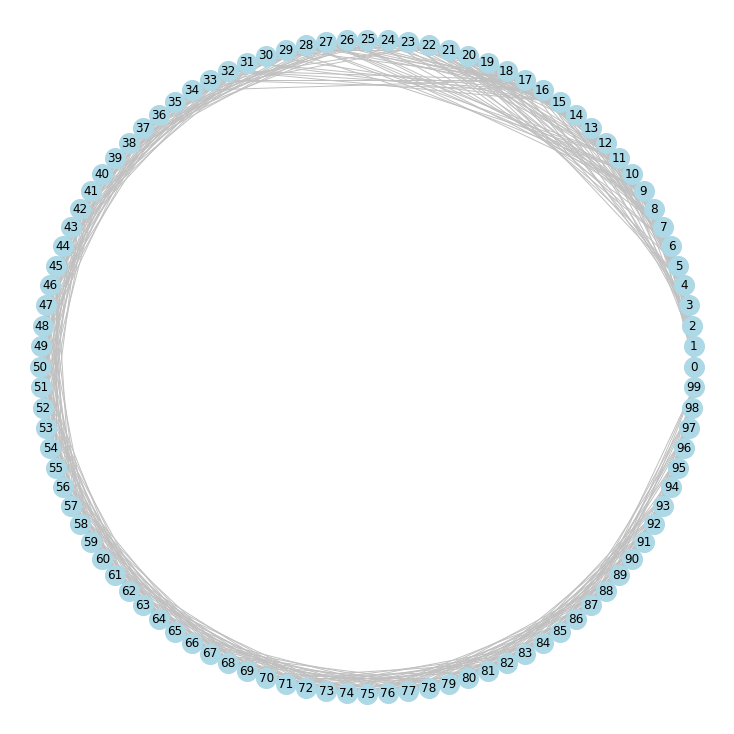

In [61]:
new_permutated_elim_graph = elimination_graph_csr(sparse_cholesky(permutated_matrix))
draw_graph(new_permutated_elim_graph, pos)

## Porównanie czasów
"6. Proszę uruchomić swój algorytm permutacji dla całej dużej (rozmiar > 100)
macierzy z zadania 4" <br>
"7. Proszę porównać czasy rzadkiej eliminacji Gaussa przed permutacją i po
permutacji dla dużej macierzy (rozmiar > 100)"

In [57]:
def compare_times(matrix):
    elim_graph = elimination_graph_csr(matrix)
    p_matrix = permutation_matrix(permutation_vector(elim_graph))
    permutated_matrix = matmul_CSR(matmul_CSR(convert_to_csr(p_matrix), matrix), convert_to_csr(p_matrix.T))
    reverse_permutated_matrix = matmul_CSR(matmul_CSR(convert_to_csr(p_matrix.T), matrix), convert_to_csr(p_matrix))
    
    start = time()
    sparse_cholesky(matrix)
    normal_time = time() - start
    
    start = time()
    sparse_cholesky(permutated_matrix)
    permutated_time = time() - start
    
    start = time()
    sparse_cholesky(reverse_permutated_matrix)
    reverse_permutated_time = time() - start
    
    df = pd.DataFrame({
         'normal order': [normal_time],
         'with permutation': [permutated_time],
         'with reversed permutation': [reverse_permutated_time],
        }, index=['time [s]']
    )
    
    df.plot(kind='bar', cmap='cividis') 
    return df

,normal order,with permutation,with reversed permutation
time [s],0.189367,0.187901,0.281535


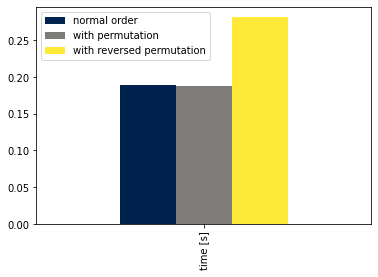

In [58]:
compare_times(convert_to_csr(matrix_3a))

,normal order,with permutation,with reversed permutation
time [s],0.197152,0.188198,0.277953


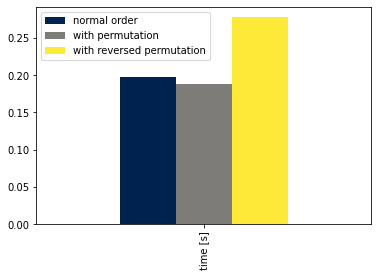

In [59]:
compare_times(convert_to_csr(matrix_4a))

Możemy zauważyć, iż zastosowanie permutacji macierzy ma wpływ na koszt czasowy eliminacji. Wynika to z różnej liczby niezerowych wartości w każdym kroku procedury. Odpowiednio zmieniając kolejność eliminacji jesteśmy w stanie zmniejszyć "fill-in".

Z powyższych testów możemy dostrzec, iż zastosowanie algorytmu Cuthill & Mckee dla tych konkretnych macierzy nie przyniosło znacznego zmniejszenia czasu obliczeń. Jednakże zastosowanie odwrotnej permutacji (czyli teoretycznie najgorszej kolejności) wyraźnie zwiększyło czas eliminacji.

## Wnioski

* Za pomocą zmiany kolejności wierszy i kolumn w macierzy jesteśmy w stanie zmniejszyć koszt czasowy algorytmów eliminacji, a przez to sprawniej dokonywać obliczenia, takie jak np. rozwiązywanie układów równań.
* Problem znalezienia optymalnej permutacji dla zadanej macierzy jest NP-zupełny. Istnieje wiele algorytmów, które nie gwarantują znalezienia najlepszej kolejności, lecz dobrze sprawdzają się dla dużej liczby macierzy wejściowych.

M. Hawryluk, N. Wolniak. 2022